# Importing Libraries

In [ ]:
import numpy as np
import os
import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ninadaithal/imagesoasis

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): Apache 2.0
100% 1.23G/1.23G [01:01<00:00, 24.9MB/s]
100% 1.23G/1.23G [01:01<00:00, 21.4MB/s]


In [ ]:
!unzip imagesoasis.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_114.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_115.jpg  
  inflating

In [ ]:
main_dir = "/content/Data"
class_mapping = {"Mild Dementia": 0, "Moderate Dementia": 1, "Non Demented": 2, "Very mild Dementia": 3}

paths = []
labels = []

for class_name in os.listdir(main_dir):
    class_dir = os.path.join(main_dir, class_name)
    if os.path.isdir(class_dir):
        label = class_mapping.get(class_name)
        for img_name in os.listdir(class_dir):
            paths.append(os.path.join(class_dir, img_name))
            labels.append(label)

# Converting labels to a numpy array
labels = np.array(labels)

# Class length
class_lengths = []
for i in range(len(class_mapping)):
    class_count = len(labels[labels == i])
    class_lengths.append(class_count)

# Print the length of each class
for class_name, length in zip(class_mapping.keys(), class_lengths):
    print(f"Class '{class_name}': {length} samples")

# Target
target_samples = 13725  # As given, the count of class 3

# Resampling
balanced_paths = []
balanced_labels = []

for class_index in np.unique(labels):
    # Extract indices of each class
    class_indices = np.where(labels == class_index)[0]
    # Resample indices
    resampled_indices = resample(class_indices, replace=len(class_indices) < target_samples, n_samples=target_samples)
    # Append to lists
    balanced_paths.extend(paths[i] for i in resampled_indices)
    balanced_labels.extend(labels[i] for i in resampled_indices)

# Print class lengths
print("Balanced class sizes:")
for class_index in np.unique(balanced_labels):
    print(f"Class {class_index} ({list(class_mapping.keys())[list(class_mapping.values()).index(class_index)]}): {np.sum(np.array(balanced_labels) == class_index)}")


Class 'Mild Dementia': 5002 samples
Class 'Moderate Dementia': 488 samples
Class 'Non Demented': 67222 samples
Class 'Very mild Dementia': 13725 samples
Balanced class sizes:
Class 0 (Mild Dementia): 13725
Class 1 (Moderate Dementia): 13725
Class 2 (Non Demented): 13725
Class 3 (Very mild Dementia): 13725


# Importing Dataset

In [ ]:

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    balanced_paths,
    balanced_labels,
    test_size=0.3,  #30% for val and test
    random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.5,  # 15-15 for val and test
    random_state=42
)

In [ ]:
from PIL import Image
import numpy as np

def process_images(paths, labels):
    data = []
    results = []
    for path, label in zip(paths, labels):
        img = Image.open(path)
        img = img.resize((128, 128))#128,128
        img_array = np.array(img)
        if img_array.shape == (128, 128, 3):  # Check if image is in the correct shape  128,128,3
            data.append(img_array)
            results.append(label)  # Directly append label, assuming it's already an integer or one-hot encoded as needed
    # Convert lists to numpy arrays for further processing
    data = np.array(data)
    results = np.array(results)
    return data, results

train_data, train_results = process_images(train_paths, train_labels)
val_data, val_results = process_images(val_paths, val_labels)
test_data, test_results = process_images(test_paths, test_labels)


# Spliting the dataset

# Creating Model: CNN

In [ ]:
model = Sequential()

model.add(Conv2D(32,kernel_size =(2,2),input_shape = (128,128,3),padding = 'Same'))
model.add(Conv2D(32,kernel_size =(2,2),activation='relu',padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size =(2,2),activation='relu',padding = 'Same'))
model.add(Conv2D(64,kernel_size =(2,2),activation='relu',padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

model.compile(loss = 'categorical_crossentropy',optimizer = 'Adamax',metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        8

In [ ]:
from tensorflow.keras.utils import to_categorical

train_results = to_categorical(train_results, num_classes=4)
val_results = to_categorical(val_results, num_classes=4)


In [ ]:
history = model.fit(
    x=train_data,
    y=train_results,
    batch_size=32,
    epochs=5,
    validation_data=(val_data, val_results),
    verbose=1


Epoch 1/5
1201/1201 [==============================] - 56s 40ms/step - loss: 0.8542 - accuracy: 0.8226 - val_loss: 0.1339 - val_accuracy: 0.9464
Epoch 2/5
1201/1201 [==============================] - 46s 39ms/step - loss: 0.1489 - accuracy: 0.9410 - val_loss: 0.0429 - val_accuracy: 0.9869
Epoch 3/5
1201/1201 [==============================] - 46s 39ms/step - loss: 0.0778 - accuracy: 0.9698 - val_loss: 0.0268 - val_accuracy: 0.9891
Epoch 4/5
1201/1201 [==============================] - 46s 39ms/step - loss: 0.0438 - accuracy: 0.9842 - val_loss: 0.0066 - val_accuracy: 0.9987
Epoch 5/5
1201/1201 [==============================] - 46s 38ms/step - loss: 0.0325 - accuracy: 0.9880 - val_loss: 0.0054 - val_accuracy: 0.9990


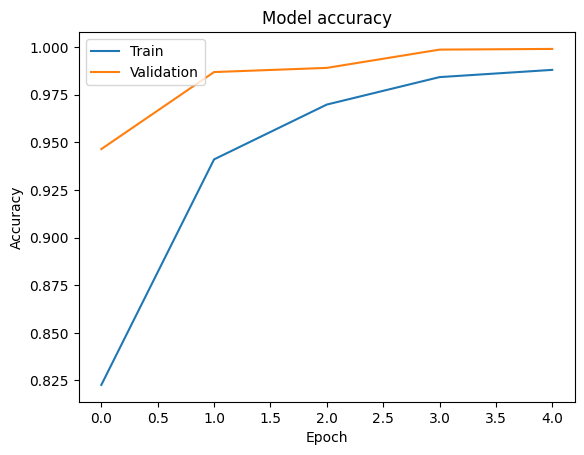

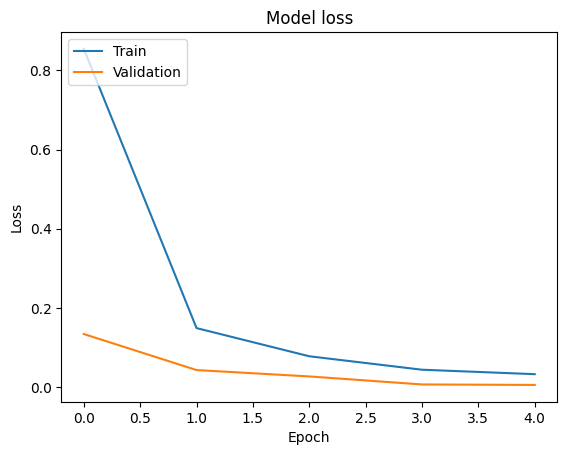

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import numpy as np

test_results = to_categorical(test_labels, num_classes=4)

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_results, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

precision = precision_score(true_classes, predicted_classes, average='macro')  # You can change average to 'micro', 'macro', or 'weighted' based on your preference
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

report = classification_report(true_classes, predicted_classes, target_names=list(class_mapping.keys()))
print("Classification Report:")
print(report)


258/258 [==============================] - 2s 9ms/step
Confusion Matrix:
[[2108    0    0    0]
 [   0 1998    0    0]
 [   1    0 2040   16]
 [   0    0    2 2070]]
Precision: 0.9977190568836993
Recall: 0.9976925715562079
F1 Score: 0.9976996458424688
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00      2108
 Moderate Dementia       1.00      1.00      1.00      1998
      Non Demented       1.00      0.99      1.00      2057
Very mild Dementia       0.99      1.00      1.00      2072

          accuracy                           1.00      8235
         macro avg       1.00      1.00      1.00      8235
      weighted avg       1.00      1.00      1.00      8235



In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.legend(['Test','Validation'],loc='upper right')
plt.show()